 # A LOGISTIC REGRESSION META-CLASSIFIER BASED ON PROBABILITIES OF NEIGHBORHOOD PIXELS GIVEN BY AN SVM

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from collections import defaultdict

import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import itertools

import random
import pandas as pd
from skimage import measure
import dill
import csv


def read_image(path):
    return plt.imread(path)

def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


def random_different_coordinates(coords, size_x, size_y, pad,cond):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        c1 = random.randint(pad + 1, size_x - (pad + 1))
        c2 = random.randint(pad + 1, size_y -( pad + 1))
        if cond:
            for c in coords:
                coordset_0 = range(int(c[0])-1,int(c[0])+2)
                coordset_1 = range(int(c[1])-1,int(c[1])+2)
                if c1 in coordset_0 and c2 in coordset_1:
                    good = False
                    break
        else:
            for c in coords:
                if c1==c[0] and c2==c[1]:
                    good = False
                    break
    return (c1,c2)

def extract_neighborhood(x, y, arr, radius):
    """ Returns a 1-d array of the values within a radius of the x,y coordinates given """
    return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)].ravel()

def check_coordinate_validity(x, y, size_x, size_y, pad):
    """ Check if a coordinate is not too close to the image edge """
    return x >= pad and y >= pad and x + pad < size_x and y + pad < size_y

def generate_labeled_data(image_path, annotation, nb_false, radius,cond):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        if check_coordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
            features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            labels.append(1)
            #features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            #labels.append(1)
        if False:
            for k in range(obj[0]-1 , obj[0]+2):
                for l in range(obj[1]-1 , obj[1]+2):
                    if check_coordinate_validity(l,k,im_array.shape[0],im_array.shape[1],radius):
                        #if k!=obj[0] or l!=obj[1]:
                        randn = random.randint(1,9)
                        if randn % 2 == 0:
                            features.append(extract_neighborhood(l,k,im_array,radius))
                            labels.append(1)
    # False samples
    for i in range(nb_false):
        c = random_different_coordinates(annotation,im_array.shape[1],im_array.shape[0],radius,cond)
        features.append(extract_neighborhood(c[1],c[0],im_array,radius))
        labels.append(0)
    return np.array(labels),np.stack(features,axis=1)

def generate_labeled_set(annotation_array, path, sequence_id_list, radius, nb_false,cond):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    for seq_id in sequence_id_list:
        for frame_id in range(1,6):
            d = generate_labeled_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius,cond)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))





In [2]:
#Read annotations/labels
train_annotation=read_annotation_file('geoSatellites/train_anno.json')

random.seed(0)

#generate training set apart from positive samples
radius=2
train_labels, train_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1,281), radius, 25,True)




In [3]:
#train with an svm-gaussian kernel(parameters after grid search)
from sklearn.svm import SVC
def myfit(train_features,train_labels):
    svc = SVC(C=100,gamma=1,probability=True)
    svc.fit(train_features,train_labels)
    return svc
svc = myfit(train_features,train_labels)

In [4]:
#generate test set and predict
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(281,561), radius, 500,True)
svc_labels = svc.predict_proba(test_features)

In [5]:
#classify as 1 or 0 according to probability
def probab_classify(threshold,svc_labels):
    svc_labels_temp = np.where(svc_labels>threshold)
    svc_labels_f = []
    last = 0 
    #print(svc_labels_temp[0])
    for i,val in enumerate(svc_labels_temp[0]):
        for j in range(last,val):
            svc_labels_f.append(0)
        if svc_labels_temp[1][i]==1:
            svc_labels_f.append(1)
        else:
            svc_labels_f.append(0)
        last = val+1
    for j in range(last,svc_labels.shape[0]):
        svc_labels_f.append(0)
    return svc_labels_f

## The modified functions so as to generate a training set that consists of a region of 9 pixels- 9 features that are the probabilities of each pixel to be positive according to svc.predict_probas

### Basic change on extract_neighborhood. The new trainset is not made of pixel values, but of pixel probabilities to be positive

In [6]:
#
def extract_stackneighborhood(x, y, arr, radius,svc):
    """ Returns a 1-d array of the predicted probas around of the x,y coordinates given """
    myarr = np.zeros((3,3))
    for i in range(x-1,x+2):
        for j in range(y-1,y+2):
            sl = svc.predict_proba([arr[(i - radius) : (i + radius + 1), (j - radius) : (j + radius + 1)].ravel()])
            #print(sl)
            myarr[i-x+1,j-y+1] = sl[0][1]
    return myarr.ravel()


In [7]:
def random_stackdifferent_coordinates(coords, size_x, size_y, pad,cond):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        c1 = random.randint(pad + 2, size_x - (pad + 2))
        c2 = random.randint(pad + 2, size_y -( pad + 2))
        if cond:
            for c in coords:
                coordset_0 = range(int(c[0])-1,int(c[0])+2)
                coordset_1 = range(int(c[1])-1,int(c[1])+2)
                if c1 in coordset_0 and c2 in coordset_1:
                    good = False
                    break
        else:
            for c in coords:
                if c1==c[0] and c2==c[1]:
                    good = False
                    break
    return (c1,c2)


def check_stackcoordinate_validity(x, y, size_x, size_y, pad):
    """ Check if a coordinate is not too close to the image edge """
    return x-1 >= pad and y-1 >= pad and x + pad + 1 < size_x and y + pad + 1 < size_y

def generate_labeled_stackdata(image_path, annotation, nb_false, radius,cond,svc):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        if check_stackcoordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
            features.append(extract_stackneighborhood(obj[1],obj[0],im_array,radius,svc))
            labels.append(1)
            #features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            #labels.append(1)
        if False:
            for k in range(obj[0]-1 , obj[0]+2):
                for l in range(obj[1]-1 , obj[1]+2):
                    if check_coordinate_validity(l,k,im_array.shape[0],im_array.shape[1],radius):
                        #if k!=obj[0] or l!=obj[1]:
                        randn = random.randint(1,9)
                        if randn % 2 == 0:
                            features.append(extract_neighborhood(l,k,im_array,radius))
                            labels.append(1)
    # False samples
    for i in range(nb_false):
        c = random_stackdifferent_coordinates(annotation,im_array.shape[1],im_array.shape[0],radius,cond)
        features.append(extract_stackneighborhood(c[1],c[0],im_array,radius,svc))
        labels.append(0)
    return np.array(labels),np.stack(features,axis=1)

def generate_labeled_stackset(annotation_array, path, sequence_id_list, radius, nb_false,cond,svc):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    for seq_id in sequence_id_list:
        for frame_id in range(1,6):
            d = generate_labeled_stackdata(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius,cond,svc)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))

In [8]:
def write_results(threshold,radius,svc_labels_f,test_labels):
    with open('geo_resultsActXXST.csv', 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=' ')
        resultwriter.writerow( ['SVC Rbf', 'RADIUS = '+str(radius),'NEGATIVE SAMPLING 20 ONE AND DONE 1-501+501-1000 PROBABS thresh = '+str(threshold)])
    report = classification_report(test_labels,svc_labels_f,output_dict=True)
    print(report)
    df = pd.DataFrame(report).transpose()
    df.to_csv('geo_resultsActXXST.csv',mode='a')
    cf = confusion_matrix(test_labels,svc_labels_f)
    print(cf)
    df = pd.DataFrame(cf)
    df.to_csv('geo_resultsActXXST.csv',mode='a')
    print("Kappa =",cohen_kappa_score(test_labels,svc_labels_f))
    with open('geo_resultsActXXST.csv', 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=' ')
        resultwriter.writerow( ["Kappa = ",cohen_kappa_score(test_labels,svc_labels_f)])

## Different results for probabilities threshold - We observe a trade-off between precision and recall

In [9]:
svc_labels_f = probab_classify(0.5,svc_labels)

In [10]:
write_results(0.5,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9992878360389355, 'recall': 0.9962514285714286, 'f1-score': 0.9977673222102437, 'support': 700000}, '1': {'precision': 0.4306791060967672, 'recall': 0.7997582594681708, 'f1-score': 0.5598646171202932, 'support': 2482}, 'accuracy': 0.9955571815363241, 'macro avg': {'precision': 0.7149834710678513, 'recall': 0.8980048440197996, 'f1-score': 0.7788159696652684, 'support': 702482}, 'weighted avg': {'precision': 0.9972788352848713, 'recall': 0.9955571815363241, 'f1-score': 0.996220130233747, 'support': 702482}}
[[697376   2624]
 [   497   1985]]
Kappa = 0.557833750578344


In [11]:
#find indexes where label prediction is 1 but the real one is 0(false positives)

def modify_trainset(svc_labels_f,train_features,train_labels):
    svc_labels_f = np.array(svc_labels_f)
    act_index = np.where(svc_labels_f==1.0)
    #print(act_index[0],act_index[0].shape[0])
    indlist=[]
    for i in act_index[0]:
        if test_labels[i]==0:
            indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features
def modify_trainset_rev(svc_labels_f,train_features,train_labels):
    svc_labels_f = np.array(svc_labels_f)
    act_index = np.where(test_labels==1.0)
    #print(act_index[0],act_index[0].shape[0])
    indlist=[]
    for i in act_index[0]:
        if svc_labels_f[i]==0:
            indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features

train_labels,train_features = modify_trainset(svc_labels_f,train_features,train_labels)
train_labels,train_features = modify_trainset_rev(svc_labels_f,train_features,train_labels)

In [12]:
svc = myfit(train_features,train_labels)
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1151,1281), radius, 500,True)
svc_labels = svc.predict_proba(test_features)

In [13]:
train_labels, train_features = generate_labeled_stackset(train_annotation,'geoSatellites/train/', range(561,851), radius, 25,True,svc)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_features,train_labels)
test_labels, test_features = generate_labeled_stackset(train_annotation,'geoSatellites/train/', range(851,1151), radius, 500,True,svc)
lr_labels = lr.predict_proba(test_features)
lr_labels_f = probab_classify(0.9,lr_labels)


C:\Users\Peris\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
print(train_features.shape)
print(train_features)

(38471, 9)
[[2.71406264e-03 1.34416626e-01 1.46610974e-01 ... 9.28848155e-02
  4.71139124e-01 6.99550479e-02]
 [7.70575780e-01 8.00886916e-01 2.54393184e-01 ... 7.18028060e-01
  3.86881537e-01 8.36354870e-03]
 [1.18645215e-01 3.15059728e-02 4.71712747e-04 ... 8.95800704e-02
  3.26425773e-02 1.47206139e-02]
 ...
 [3.75077603e-02 3.78291765e-02 6.74452422e-03 ... 1.00000010e-07
  1.00000010e-07 1.00000010e-07]
 [1.52788146e-01 8.03751957e-02 4.90040977e-03 ... 2.85349833e-02
  2.38648652e-03 8.80113191e-04]
 [1.68585589e-02 4.09533774e-02 4.58524816e-03 ... 3.69447796e-03
  1.38465435e-03 4.98950422e-03]]


In [15]:
lr_labels_f = probab_classify(0.5,lr_labels)
write_results(0.5,radius,lr_labels_f,test_labels)

{'0': {'precision': 0.9994032680087575, 'recall': 0.9981773333333334, 'f1-score': 0.9987899244870186, 'support': 750000}, '1': {'precision': 0.6292378627610523, 'recall': 0.8384531984098301, 'f1-score': 0.7189339944220637, 'support': 2767}, 'accuracy': 0.9975902238009902, 'macro avg': {'precision': 0.8143205653849048, 'recall': 0.9183152658715817, 'f1-score': 0.8588619594545412, 'support': 752767}, 'weighted avg': {'precision': 0.9980426243084884, 'recall': 0.9975902238009902, 'f1-score': 0.9977612378436221, 'support': 752767}}
[[748633   1367]
 [   447   2320]]
Kappa = 0.7177486110059128


In [16]:
#find indexes where label prediction is 1 but the real one is 0(false positives)

train_labels,train_features = modify_trainset(lr_labels_f,train_features,train_labels)
train_labels,train_features = modify_trainset_rev(lr_labels_f,train_features,train_labels)

In [17]:
lr.fit(train_features,train_labels)
test_labels, test_features = generate_labeled_stackset(train_annotation,'geoSatellites/train/', range(1151,1281), radius, 500,True,svc)
svc_labels = lr.predict_proba(test_features)
svc_labels_f = probab_classify(0.5,svc_labels)
write_results(0.5,radius,svc_labels_f,test_labels)

C:\Users\Peris\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'0': {'precision': 0.9989024300260712, 'recall': 0.9997138461538462, 'f1-score': 0.999307973376967, 'support': 325000}, '1': {'precision': 0.8850432632880099, 'recall': 0.6672879776328052, 'f1-score': 0.760892667375133, 'support': 1073}, 'accuracy': 0.998619940933472, 'macro avg': {'precision': 0.9419728466570405, 'recall': 0.8335009118933256, 'f1-score': 0.88010032037605, 'support': 326073}, 'weighted avg': {'precision': 0.9985277566065917, 'recall': 0.998619940933472, 'f1-score': 0.9985234262867755, 'support': 326073}}
[[324907     93]
 [   357    716]]
Kappa = 0.7602142966986767


### ACTIVE LEARNING SECTION

We readjust the training set including the samples that have been misclassified

In [11]:
#find indexes where label prediction is 1 but the real one is 0(false positives)


def stack_set(svc_labels_f):
    svc_labels_f = np.array(svc_labels_f)
    act_index = np.where(svc_labels_f==1.0)
    #print(act_index[0],act_index[0].shape[0])
    indlist=[]
    for i in act_index[0]:
        if test_labels[i]==0:
            indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features
def modify_trainset(svc_labels_f,train_features,train_labels):
    svc_labels_f = np.array(svc_labels_f)
    act_index = np.where(svc_labels_f==1.0)
    #print(act_index[0],act_index[0].shape[0])
    indlist=[]
    for i in act_index[0]:
        if test_labels[i]==0:
            indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features
def modify_trainset_rev(svc_labels_f,train_features,train_labels):
    svc_labels_f = np.array(svc_labels_f)
    act_index = np.where(test_labels==1.0)
    #print(act_index[0],act_index[0].shape[0])
    indlist=[]
    for i in act_index[0]:
        if svc_labels_f[i]==0:
            indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features



In [12]:
train_labels,train_features = modify_trainset(svc_labels_f,train_features,train_labels)
train_labels,train_features = modify_trainset_rev(svc_labels_f,train_features,train_labels)

In [31]:
#train_labels,train_features = modify_trainset(svc_labels_f,train_features,train_labels)

In [32]:
#svc = myfit(train_features,train_labels)
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(801,1001), radius, 500,True)
svc_labels = svc.predict_proba(test_features)
svc_labels_f = probab_classify(0.9,svc_labels)
write_results(0.9,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9991340446728714, 'recall': 0.996878, 'f1-score': 0.9980047473597692, 'support': 500000}, '1': {'precision': 0.4495768688293371, 'recall': 0.7469244288224957, 'f1-score': 0.561303103675985, 'support': 1707}, 'accuracy': 0.9960275619036609, 'macro avg': {'precision': 0.7243554567511042, 'recall': 0.8719012144112479, 'f1-score': 0.7796539255178772, 'support': 501707}, 'weighted avg': {'precision': 0.9972642399877366, 'recall': 0.9960275619036609, 'f1-score': 0.996518920560924, 'support': 501707}}
[[498439   1561]
 [   432   1275]]
Kappa = 0.5594316021404093


In [33]:
svc_labels_f = probab_classify(0.5,svc_labels)
write_results(0.5,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9996114620702429, 'recall': 0.993082, 'f1-score': 0.9963360334853631, 'support': 500000}, '1': {'precision': 0.30444399758696966, 'recall': 0.8869361452841242, 'f1-score': 0.4532934131736527, 'support': 1707}, 'accuracy': 0.992720851014636, 'macro avg': {'precision': 0.6520277298286062, 'recall': 0.9400090726420621, 'f1-score': 0.7248147233295079, 'support': 501707}, 'weighted avg': {'precision': 0.9972462352309264, 'recall': 0.992720851014636, 'f1-score': 0.9944883938214316, 'support': 501707}}
[[496541   3459]
 [   193   1514]]
Kappa = 0.45050975863352904


In [34]:
train_labels,train_features = modify_trainset(svc_labels_f,train_features,train_labels)
svc = myfit(train_features,train_labels)
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1001,1151), radius, 500,False)
svc_labels = svc.predict_proba(test_features)
svc_labels_f = probab_classify(0.9,svc_labels)
write_results(0.9,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9982695507487521, 'recall': 0.9999333333333333, 'f1-score': 0.9991007493755204, 'support': 375000}, '1': {'precision': 0.970344009489917, 'recall': 0.5572207084468664, 'f1-score': 0.7079186499350931, 'support': 1468}, 'accuracy': 0.9982070189232551, 'macro avg': {'precision': 0.9843067801193346, 'recall': 0.7785770208901, 'f1-score': 0.8535096996553068, 'support': 376468}, 'weighted avg': {'precision': 0.9981606578426673, 'recall': 0.9982070189232551, 'f1-score': 0.9979653133703924, 'support': 376468}}
[[374975     25]
 [   650    818]]
Kappa = 0.7070853589305424


In [39]:
svc_labels_f = probab_classify(0.5,svc_labels)
write_results(0.5,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9990458295019923, 'recall': 0.9995653333333333, 'f1-score': 0.9993055138997193, 'support': 375000}, '1': {'precision': 0.8719560094265515, 'recall': 0.7561307901907357, 'f1-score': 0.809923385625684, 'support': 1468}, 'accuracy': 0.9986160842355791, 'macro avg': {'precision': 0.9355009194642718, 'recall': 0.8778480617620346, 'f1-score': 0.9046144497627017, 'support': 376468}, 'weighted avg': {'precision': 0.9985502552277624, 'recall': 0.9986160842355791, 'f1-score': 0.9985670368862514, 'support': 376468}}
[[374837    163]
 [   358   1110]]
Kappa = 0.809232427216719


In [40]:
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1001,1151), radius, 500,True)
svc_labels = svc.predict_proba(test_features)
svc_labels_f = probab_classify(0.9,svc_labels)
write_results(0.9,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9982695461418866, 'recall': 0.9999306666666666, 'f1-score': 0.9990994159525941, 'support': 375000}, '1': {'precision': 0.9691943127962085, 'recall': 0.5572207084468664, 'f1-score': 0.7076124567474048, 'support': 1468}, 'accuracy': 0.9982043626549932, 'macro avg': {'precision': 0.9837319294690475, 'recall': 0.7785756875567665, 'f1-score': 0.8533559363499994, 'support': 376468}, 'weighted avg': {'precision': 0.9981561701243993, 'recall': 0.9982043626549932, 'f1-score': 0.997962791176748, 'support': 376468}}
[[374974     26]
 [   650    818]]
Kappa = 0.7067776621045294


In [46]:
svc_labels_f = probab_classify(0.65,svc_labels)
write_results(0.65,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9988464407502131, 'recall': 0.9998053333333333, 'f1-score': 0.9993256570179647, 'support': 375000}, '1': {'precision': 0.9341155234657039, 'recall': 0.7050408719346049, 'f1-score': 0.8035714285714285, 'support': 1468}, 'accuracy': 0.9986559282595068, 'macro avg': {'precision': 0.9664809821079585, 'recall': 0.852423102633969, 'f1-score': 0.9014485427946966, 'support': 376468}, 'weighted avg': {'precision': 0.9985940288942954, 'recall': 0.9986559282595068, 'f1-score': 0.9985623326255607, 'support': 376468}}
[[374927     73]
 [   433   1035]]
Kappa = 0.8029103001703581


In [ ]:
import joblib
joblib.dump()

In [15]:
def modify_trainset_rev(svc_labels_f,train_features,train_labels):
    svc_labels_f = np.array(svc_labels_f)
    act_index = np.where(test_labels==1.0)
    #print(act_index[0],act_index[0].shape[0])
    indlist=[]
    for i in act_index[0]:
        if svc_labels_f[i]==0:
            indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features
train_labels,train_features = modify_trainset_rev(svc_labels_f,train_features,train_labels)
svc = myfit(train_features,train_labels)
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(601,701), radius, 500,False)
svc_labels = svc.predict_proba(test_features)
svc_labels_f = probab_classify(0.9,svc_labels)
write_results(0.9,radius,svc_labels_f,test_labels)


{'0': {'precision': 0.9983465859395905, 'recall': 0.999908, 'f1-score': 0.9991266829339457, 'support': 250000}, '1': {'precision': 0.9451073985680191, 'recall': 0.4888888888888889, 'f1-score': 0.644426362896664, 'support': 810}, 'accuracy': 0.9982576452294566, 'macro avg': {'precision': 0.9717269922538048, 'recall': 0.7443984444444445, 'f1-score': 0.8217765229153049, 'support': 250810}, 'weighted avg': {'precision': 0.9981746480512648, 'recall': 0.9982576452294566, 'f1-score': 0.9979811653739195, 'support': 250810}}
[[249977     23]
 [   414    396]]
Kappa = 0.6436416346879674


In [16]:
svc_labels_f = probab_classify(0.9,svc_labels)
write_results(0.9,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9983465859395905, 'recall': 0.999908, 'f1-score': 0.9991266829339457, 'support': 250000}, '1': {'precision': 0.9451073985680191, 'recall': 0.4888888888888889, 'f1-score': 0.644426362896664, 'support': 810}, 'accuracy': 0.9982576452294566, 'macro avg': {'precision': 0.9717269922538048, 'recall': 0.7443984444444445, 'f1-score': 0.8217765229153049, 'support': 250810}, 'weighted avg': {'precision': 0.9981746480512648, 'recall': 0.9982576452294566, 'f1-score': 0.9979811653739195, 'support': 250810}}
[[249977     23]
 [   414    396]]
Kappa = 0.6436416346879674


In [17]:
train_labels,train_features = modify_trainset_rev(svc_labels_f,train_features,train_labels)
svc = myfit(train_features,train_labels)
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(701,801), radius, 500,False)
svc_labels = svc.predict_proba(test_features)
svc_labels_f = probab_classify(0.9,svc_labels)
write_results(0.9,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9986734220915179, 'recall': 0.999744, 'f1-score': 0.9992084242845833, 'support': 250000}, '1': {'precision': 0.8605664488017429, 'recall': 0.5433287482806052, 'f1-score': 0.6661045531197302, 'support': 727}, 'accuracy': 0.9984205929158009, 'macro avg': {'precision': 0.9296199354466304, 'recall': 0.7715363741403025, 'f1-score': 0.8326564887021568, 'support': 250727}, 'weighted avg': {'precision': 0.9982729715234432, 'recall': 0.9984205929158009, 'f1-score': 0.9982425669403928, 'support': 250727}}
[[249936     64]
 [   332    395]]
Kappa = 0.6653534879858846


In [18]:
svc_labels_f = probab_classify(0.5,svc_labels)
write_results(0.5,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9993435247118914, 'recall': 0.99862, 'f1-score': 0.998981631350549, 'support': 250000}, '1': {'precision': 0.6200440528634361, 'recall': 0.7744154057771664, 'f1-score': 0.6886850152905198, 'support': 727}, 'accuracy': 0.9979699035205623, 'macro avg': {'precision': 0.8096937887876637, 'recall': 0.8865177028885831, 'f1-score': 0.8438333233205344, 'support': 250727}, 'weighted avg': {'precision': 0.9982437200796266, 'recall': 0.9979699035205623, 'f1-score': 0.9980819051947075, 'support': 250727}}
[[249655    345]
 [   164    563]]
Kappa = 0.6876791673115328


In [19]:
train_labels,train_features = modify_trainset(svc_labels_f,train_features,train_labels)
svc = myfit(train_features,train_labels)
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(801,901), radius, 500,False)
svc_labels = svc.predict_proba(test_features)
svc_labels_f = probab_classify(0.9,svc_labels)
write_results(0.9,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.998219041876475, 'recall': 0.999924, 'f1-score': 0.999070793542315, 'support': 250000}, '1': {'precision': 0.9535452322738386, 'recall': 0.4665071770334928, 'f1-score': 0.6265060240963856, 'support': 836}, 'accuracy': 0.9981461991101755, 'macro avg': {'precision': 0.9758821370751568, 'recall': 0.7332155885167464, 'f1-score': 0.8127884088193502, 'support': 250836}, 'weighted avg': {'precision': 0.9980701505497603, 'recall': 0.9981461991101755, 'f1-score': 0.9978290892125665, 'support': 250836}}
[[249981     19]
 [   446    390]]
Kappa = 0.6256863598032716


In [20]:
svc_labels_f = probab_classify(0.5,svc_labels)
write_results(0.5,radius,svc_labels_f,test_labels)

{'0': {'precision': 0.9991041505027155, 'recall': 0.999272, 'f1-score': 0.999188068202271, 'support': 250000}, '1': {'precision': 0.7707808564231738, 'recall': 0.7320574162679426, 'f1-score': 0.750920245398773, 'support': 836}, 'accuracy': 0.9983814125564113, 'macro avg': {'precision': 0.8849425034629447, 'recall': 0.8656647081339713, 'f1-score': 0.875054156800522, 'support': 250836}, 'weighted avg': {'precision': 0.9983431820857, 'recall': 0.9983814125564113, 'f1-score': 0.9983606275643094, 'support': 250836}}
[[249818    182]
 [   224    612]]
Kappa = 0.750108854424303


In [ ]:
import time
start_time = time.time()

#test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(501,550), radius, 500)
#myframe = 1
from multiprocessing import Pool
sequencerange = range(1201,1281)
framerange = range(1,6)
sub_list = []
for myseq in sequencerange:
    for myframe in framerange:
        sub_list.append(predict_objects(myseq,myframe,svc,radius,1,3))
        #print(len(sub_list))
        #print(sub_list[0:5])
nb_procs = 2
#p = Pool(processes=nb_procs)
submission=[]
for s in range(1201,1281):
    #print(s)
    for fr in range(1,6):
        if s in sequencerange:
            submission.append({"sequence_id" : s, 
                                    "frame" : fr, 
                                    "num_objects" : len(sub_list[(s-1201)*5 + fr-1]), 
                                    "object_coords" : sub_list[(s-1201)*5 + fr-1]})
        else:
            submission.append({"sequence_id" : s,
                                    "frame" : fr,
                                    "num_objects" : 0,
                                    "object_coords" : []})
with open('my_submissionSmall_nothread_rad3_neg50_SvmRbf_train1201-1280Probab+Act.json', 'w') as outfile:
    json.dump(submission, outfile)

### Single Frame

In [21]:



sequence_id, frame_id = 1111, 1
target_image = plt.imread(f"geoSatellites/train/{sequence_id}/{frame_id}.png")
print(train_annotation[sequence_id][frame_id])
pred_image=classify_image(target_image, svc, radius)
plt.figure(figsize=(15,10))
plt.imshow(pred_image, interpolation='None' )
#plt.axis('off')
plt.show()

[[155.4100227790433, 358.0763097949886], [301.749430523918, 430.69134396355355]]


NameError: name 'pred_image' is not defined

<Figure size 1080x720 with 0 Axes>

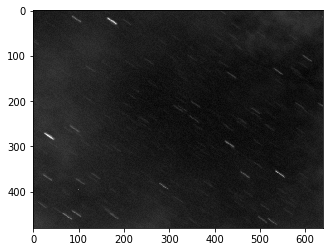

In [30]:
plt.imshow(target_image, cmap='gray')
#plt.axis('off')
plt.show()

[[232.2171630859375, 178.0972900390625]]


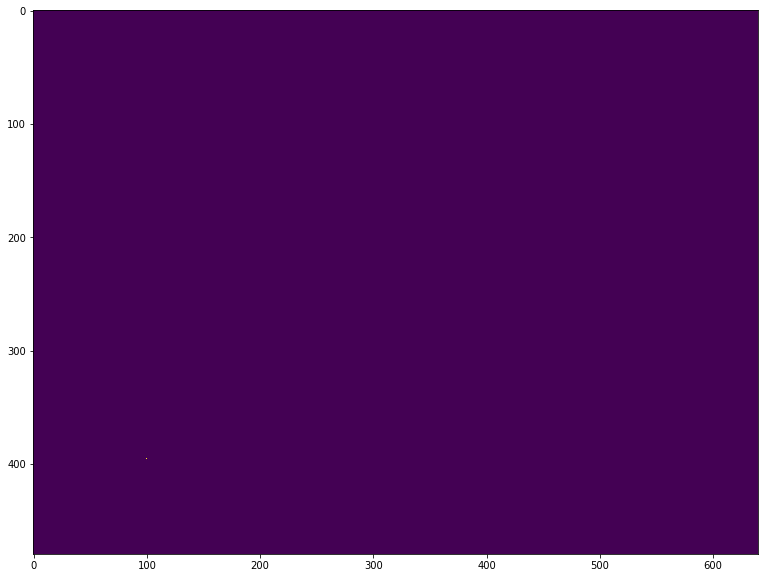

[[203.62689208984375, 206.181396484375]]


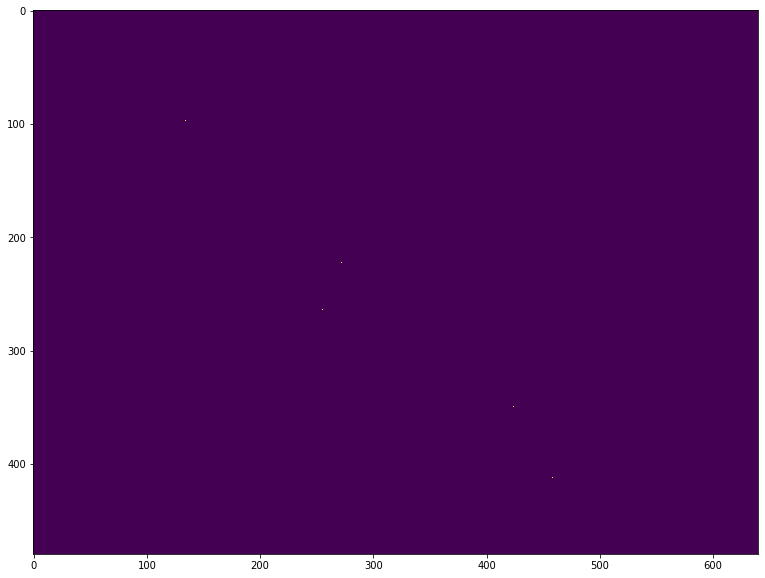

[[174.4354248046875, 234.0654296875]]


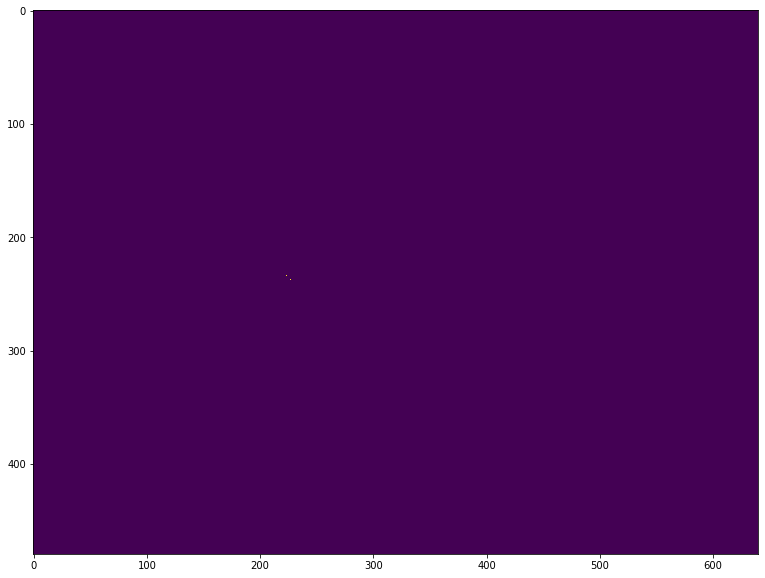

[[145.40966796875, 262.17919921875]]


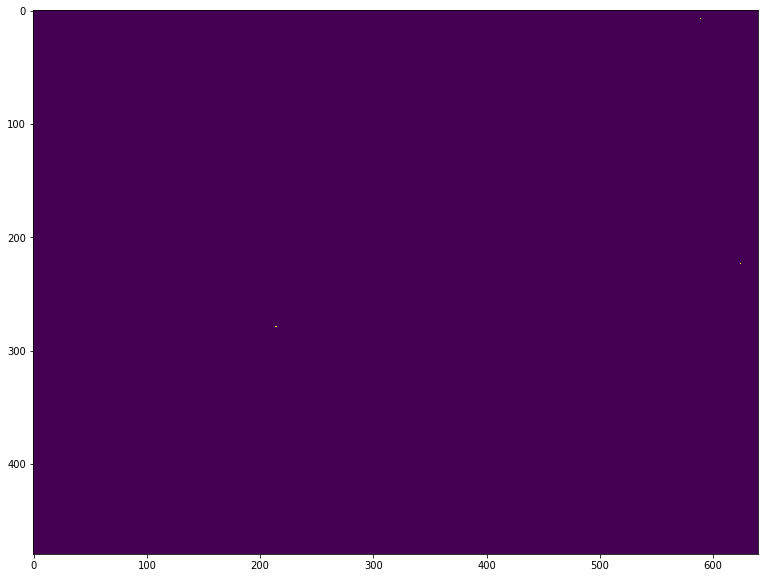

[[116.3717041015625, 290.829345703125]]


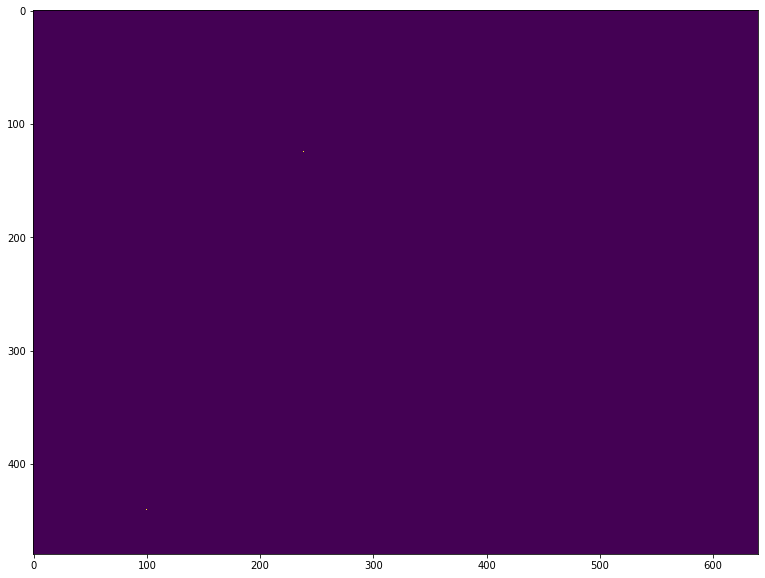

In [24]:
sequence_id=1007
framerange = range(1,6)
pred_image = []
for frame_id in framerange:
    print(train_annotation[sequence_id][frame_id])
    target_image = plt.imread(f"geoSatellites/train/{sequence_id}/{frame_id}.png")
    pred_image.append(classify_image(target_image, svc, radius))
    plt.figure(figsize=(15,10))
    plt.imshow(pred_image[frame_id-1], interpolation='None', )
    #plt.axis('off')
    plt.show()

In [26]:
for predimg in pred_image:
    centroids,sizes = extract_centroids(predimg,0)
    print(len(centroids.values()))
    print(centroids)

1
{1: array([395., 100.])}
5
{1: array([ 97., 134.]), 2: array([222., 272.]), 3: array([264., 255.]), 4: array([349., 424.]), 5: array([412., 458.])}
2
{1: array([234., 223.]), 2: array([237., 227.])}
3
{1: array([  7., 589.]), 2: array([223., 624.]), 3: array([279., 214.])}
2
{1: array([124., 238.]), 2: array([440., 100.])}


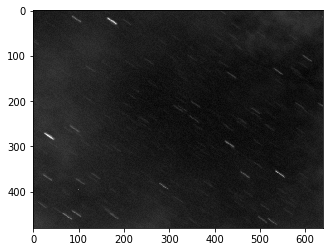

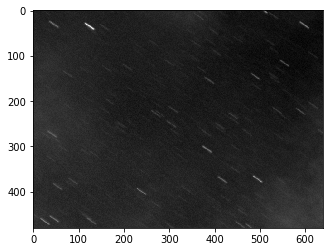

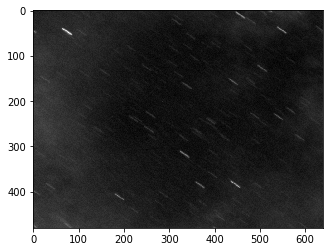

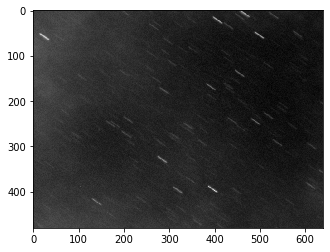

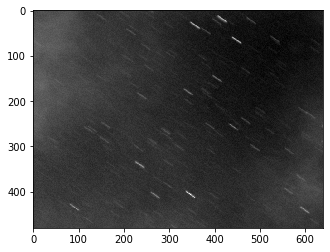

In [32]:
sequence_id=1007
framerange = range(1,6)
#pred_image = []
for frame_id in framerange:
    target_image = plt.imread(f"geoSatellites/train/{sequence_id}/{frame_id}.png")
    #pred_image.append(classify_image(target_image, svc, radius))
    #plt.figure(figsize=(15,10))
    #plt.imshow(pred_image[frame_id-1], interpolation='None', )
    plt.imshow(target_image, cmap='gray')
    #plt.axis('off')
    plt.show()

In [34]:
import joblib
joblib.dump(svc,'actlearnsvm.pkl')

['actlearnsvm.pkl']

In [54]:
sequencerange=range(1,1281)
framerange = range(2,6)
pred_image = []
sm1=0
sm2=0
ssum=0
biggest1 = -1
biggest2 = -1
smallest1 = 641
smallest2 = 641
for sequence_id in sequencerange:
    ann = train_annotation[sequence_id][1]
    last = ann
    print(sequence_id)
    for frame_id in framerange:
        ann = train_annotation[sequence_id][frame_id] 
        for i,val in enumerate(ann):
            ssum+=1
            print(abs(val[1]-last[i][1]))
            print(abs(val[0]-last[i][0]))
            if (abs(val[1]-last[i][1])) > biggest1:
                biggest1 = abs(val[1]-last[i][1])
            if (abs(val[1]-last[i][1])) < smallest1:
                smallest1 = abs(val[1]-last[i][1])
            if (abs(val[0]-last[i][0])) > biggest2:
                biggest2 = abs(val[0]-last[i][0])
            if (abs(val[0]-last[i][0])) < smallest2:
                smallest2 = abs(val[0]-last[i][0])
            #if (abs(val[0]-last[i][0])) == 0:
            #    print("000!!000")
            sm1 += abs(val[1]-last[i][1])
            #print(sm1)
            sm2 += abs(val[0]-last[i][0])
        last = ann
avg1 = float(sm1)/ssum
avg2 = sm2/ssum
print(avg1,avg2)
print(ssum)
print(biggest1,biggest2)
print(smallest1,smallest2)

1
23.0
28.0
23.0
28.0
21.21557486631019
26.985628342246173
23.0
28.0
23.0
28.0
21.942847593582883
27.330548128342116
23.0
28.0
23.0
28.0
22.06082887700535
27.56617647058829
23.0
28.0
23.0
28.0
21.5177139037433
27.03375668449189
2
26.0
27.0
26.0
27.0
26.0
27.0
26.0
27.0
3
21.5374755859375
27.99822998046875
21.0
28.0
21.40924072265625
28.28887939453125
21.0
28.0
21.5726318359375
27.87481689453125
21.0
28.0
21.41436767578125
27.9981689453125
21.0
28.0
4
26.781082887700563
9.117312834224663
26.648395721925112
10.44251336898401
27.12332887700535
9.61864973262027
26.54445187165777
10.908756684491891
5
29.001220703125
19.97021484375
29.0
20.0
28.998779296875
20.02978515625
29.0
20.0
29.0
20.0
29.0
20.0
29.0
20.0
29.0
20.0
6
18.370320855614978
24.5
17.574866310160473
24.778074866310135
18.20320855614966
24.951871657754054
17.83823529411768
24.955882352941217
7
24.0
20.0
24.0
20.0
24.0
20.0
24.0
20.0
8
21.1278076171875
21.9378662109375
21.1707763671875
21.748779296875
21.6270751953125
22.209167

21.0
25.0
21.0
25.0
21.0
25.0
21.0
73
16.0
12.0
16.0
12.0
16.0
12.0
16.0
12.0
74
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
16.0
13.0
75
22.66729736328125
21.2203369140625
21.0
20.0
22.5211181640625
20.846435546875
21.0
20.0
22.81298828125
21.1217041015625
21.0
20.0
22.90374755859375
21.04779052734375
21.0
20.0
76
26.0
25.0
27.4599609375
14.720458984375
26.0
25.0
27.07440185546875
15.8209228515625
26.0
25.0
27.048583984375
16.5682373046875
26.0
25.0
28.50994873046875
14.9818115234375
77
24.0
20.0
24.0
20.0
24.0
20.0
24.0
20.0
24.0
20.0
24.0
20.0
24.0
20.0
24.0
20.0
78
13.15771484375
16.43603515625
20.0
21.0
13.9503173828125
16.759765625
20.0
21.0
14.3497314453125
16.7960205078125
20.0
21.0
14.0179443359375
16.583984375
20.0
21.0
79
12.0
11.0
12.0723876953125
11.04083251953125
12.0
11.0
14.00360107421875
11.07421875
10.8955078125
10.958740234375
13.935333251953125
10.58074951171875

24.8099365234375
20.0
20.0
6.972900390625
25.2144775390625
20.0
20.0
6.1005859375
26.49676513671875
20.0
20.0
9.6065673828125
23.86639404296875
20.0
20.0
129
22.0
27.0
22.0
27.0
20.851318359375
28.18560791015625
22.0
27.0
22.0
27.0
21.3636474609375
27.5693359375
22.0
27.0
22.0
27.0
20.89947509765625
28.374755859375
22.0
27.0
22.0
27.0
21.19683837890625
28.4739990234375
130
11.0
15.0
11.0
15.0
11.0
15.0
11.0
15.0
131
24.0
25.0
24.0
25.0
24.236083984375
23.8564453125
24.0
25.0
24.0
25.0
24.2913818359375
24.03924560546875
24.0
25.0
24.0
25.0
24.67926025390625
23.63128662109375
24.0
25.0
24.0
25.0
24.15618896484375
24.1746826171875
132
133
25.0
27.0
25.0
27.0
25.0
27.0
25.0
27.0
134
22.0
26.0
22.0
26.0
22.0
26.0
22.0
26.0
135
27.0
25.0
27.0
25.0
27.0
25.0
27.0
25.0
136
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
137
138
17.0
10.0
17.0
10.0
17.0
10.0
17.0
10.0
15.597927807486656
5.87533422459893
17.0
10.0
17.0
10.0
17.0
10.0
17.0
10.0
14.984291443850282
5.12533422459893
17.0
10.0
17.0
10.0
17.0

30.689171122994708
19.844251336898424
31.0741978609625
19.888368983957207
30.787098930481307
19.99364973262027
30.390708556149775
19.58255347593581
282
15.0
12.0
14.981091529852279
12.035812200682813
15.0
12.0
15.0
12.0
15.0
12.0
15.018908470147721
11.964187799317187
15.0
12.0
15.029338653074888
12.045987215909122
15.0
12.0
15.0
12.0
15.0
12.0
14.970661346925112
11.954012784090878
15.0
12.0
15.0
12.0
15.0
12.0
15.0
12.0
283
21.1490478515625
28.8878173828125
20.89453125
28.66278076171875
20.172119140625
26.807861328125
21.0162353515625
28.4686279296875
284
25.529411764705856
24.05882352941171
25.049131016042793
23.761697860962613
24.51737967914437
23.23262032085563
24.8783422459893
23.875668449197747
285
29.0
28.0
18.72827540106948
25.194852941176464
29.0
28.0
21.396056149732658
25.567179144385022
29.0
28.0
17.79445187165777
24.87466577540107
29.0
28.0
19.443181818181756
26.199866310160417
286
13.0
11.0
13.0
11.0
13.0
11.0
13.0
11.0
13.362633689839527
11.000334224598873
13.0
11.0
13.0
1

25.60767742073017
17.196173090275806
23.0
24.0
26.49899732620321
15.931483957219143
414
415
23.97808837890625
17.65386962890625
24.185302734375
18.04229736328125
24.11212158203125
18.2734375
24.0565185546875
18.30462646484375
24.00067138671875
18.22894287109375
24.32476806640625
18.44384765625
23.970703125
18.3673095703125
23.3297119140625
17.646484375
416
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
417
19.87103271484375
20.48065185546875
20.0
20.0
11.79656982421875
16.1641845703125
19.9412841796875
20.3876953125
20.0
20.0
12.250244140625
16.7825927734375
20.00457763671875
20.548828125
20.0
20.0
10.747314453125
16.0506591796875
19.82073974609375
20.5723876953125
20.0
20.0
10.607666015625
16.38671875
418
26.0
29.0
26.0
29.0
26.0
29.0
26.0
29.0
419
420
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
421
20.0
21.0
20.06817626953125
21.5335693359375
20.0
21.0
20.0770263671875
21.42919921875
20.0
21.0
19.9735107421875
21.22607421875
20.0
21.0
19.9755859375
21.132

23.0
28.0
23.0
466
18.951871657753998
20.794117647058783
18.78205431322226
20.780970135998132
18.979977772339225
20.97036676239759
18.8783422459893
21.11363636363626
467
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
22.0
20.0
468
21.0225830078125
25.308837890625
20.0
27.0
20.0
27.0
21.10369873046875
27.06610107421875
20.83758544921875
25.9371337890625
20.0
27.0
20.0
27.0
20.99139404296875
27.2080078125
20.8643798828125
25.735595703125
20.0
27.0
20.0
27.0
21.1746826171875
27.19427490234375
20.7392578125
25.9112548828125
20.0
27.0
20.0
27.0
21.17742919921875
27.167236328125
469
29.39371657754009
26.135695187165766
29.95016445495088
26.23978276584944
29.683859609220235
25.850792100460694
28.942179144385022
26.28509358288784
470
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
471
13.0
13.0
13.0
13.0
13.0
13.0
13.0
13.0
472
24.387032085561486
24.309491978609685
20.0
23.0
23.766042780748663
24.847

10.0
10.0
2.396056149732658
12.432820855614978
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
1.2055481283422296
13.12533422459893
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
0.44318181818175617
11.800133689839583
537
21.0
26.0
20.541109625668355
26.622660427807546
21.0
26.0
20.395425767117786
26.66508944124348
21.0
26.0
20.33418653234753
26.638052269986474
21.0
26.0
20.41945187165777
26.464906417112275
538
20.0
28.0
20.0
28.0
20.0
28.0
19.9947277782515
28.04035895265133
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0052722217485
27.95964104734867
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
539
22.0
29.0
22.0
29.0
22.0
29.0
22.0
29.0
540
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
20.0
25.0
541
542
27.39404296875
22.97509765625
25.4522705078125
21.67559814453125
27.2041015625
22.8245849609375
25.84796142578125


22.91326904296875
11.7333984375
24.2340087890625
21.299560546875
23.19580078125
11.32379150390625
668
26.94970703125
29.698486328125
27.180908203125
30.2884521484375
26.9427490234375
30.135009765625
26.4078369140625
30.1751708984375
669
22.0
27.0
22.0
27.0
22.492981283422523
26.981617647058783
22.0
27.0
22.0
27.0
22.03647539985127
26.98111440683124
22.0
27.0
22.0
27.0
22.22321711351765
27.010529978195336
22.0
27.0
22.0
27.0
22.18883689839572
27.019719251336937
670
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
671
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
19.324866310160473
19.62566844919786
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
20.447860962566835
19.859625668449212
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
19.81283422459893
19.83556149732624
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
20.360962566844933
19.814171122994708
672
22.0
22.0
19.84295654296875
15.9891357421875
22.0
22.0
19.3812255859375
15.8892822265625
22.0
22.0
19.26690673828125
14.9659423828125


28.0
28.0
28.0
28.0
27.7376708984375
29.3533935546875
28.0
28.0
28.0
28.0
27.87750244140625
28.9688720703125
28.0
28.0
28.0
28.0
27.8638916015625
29.004150390625
787
788
24.0
28.0
24.0
28.0
24.0
28.0
24.0
28.0
789
37.96966552734375
25.46185302734375
33.93865966796875
26.4635009765625
34.88909912109375
26.14227294921875
38.8214111328125
25.429931640625
790
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
791
792
793
23.9794921875
21.537109375
24.0
21.0
24.2744140625
21.4190673828125
24.0
21.0
23.8548583984375
21.56787109375
24.0
21.0
23.9837646484375
21.4140625
24.0
21.0
794
25.9688720703125
28.40838623046875
25.938720703125
28.5721435546875
25.89556884765625
28.28741455078125
26.23187255859375
28.45025634765625
795
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
25.0
22.0
796
11.0
12.0
11.0
12.0
11.0
12.0
11.0
12.0


13.0
11.0
10.824676513671875
10.7803955078125
13.0
11.0
14.242828369140625
12.2100830078125
13.0
11.0
13.0
11.0
13.0
11.0
13.0
11.0
13.0
11.0
11.02264404296875
10.85693359375
13.0
11.0
13.892333984375
11.52978515625
13.0
11.0
13.0
11.0
13.02886962890625
11.0208740234375
13.0
11.0
13.0
11.0
9.55072021484375
10.396728515625
13.0
11.0
14.1126708984375
11.876953125
13.0
11.0
895
896
897
23.465240641711034
23.96256684491982
23.190816831281154
23.902703331367434
23.19989172486862
23.971293994835833
23.27874331550811
23.603609625668355
898
18.10758971987525
9.462794249244098
19.0
10.0
18.976138828633395
10.409978308025984
18.129067245119302
9.842733188720217
19.0
10.0
19.023861171366605
9.590021691974016
18.0782463757065
9.996501395362884
19.0
10.0
19.0
10.0
18.03090626060083
9.434749034858328
19.0
10.0
19.0
10.0
899
22.0
22.0
22.0
22.0
22.0
22.0
22.01409912109375
22.04510498046875
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22

13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
13.0
14.0
991
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
20.9730224609375
19.9620361328125
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0
20.0
21.0269775390625
20.0379638671875
21.0
20.0
992
21.2059326171875
26.42034912109375
21.4307861328125
26.188232421875
21.238037109375
26.46026611328125
21.4246826171875
26.16668701171875
993
24.0
29.0
24.0
29.0
24.0
29.0
24.0
29.0
994
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
20.0
23.0
995
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
996
21.1046142578125
27.28436279296875
21.49237060546875
27.46551513671875
21.22698974609375
27.5228271484375
21.748046875
27.83782958984375
997
15.0
11.0


27.0843505859375
21.22674560546875
28.0
26.0
28.0
26.0
28.0
26.0
27.48126220703125
21.4715576171875
1042
39.0262451171875
38.54681396484375
38.8018798828125
39.0091552734375
39.862548828125
39.76275634765625
39.70623779296875
40.0672607421875
1043
1044
1045
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
18.0
14.0
1046
1047
24.05291748046875
27.54010009765625
24.09033203125
27.4637451171875
24.3214111328125
27.80621337890625
24.48785400390625
27.880615234375
24.32745361328125
27.66900634765625
24.5372314453125
27.86456298828125
24.08734130859375
27.68988037109375
23.80291748046875
27.5252685546875
1048
26.0
20.0
26.0
20.0
26.0
20.0
26.0
20.0
1049
9.32987967914437
16.323863636363626
9.564695084531877
16.26351243335057
9.986441279104497
16.13454906397567
9.4375
15.950200534759347
1050
28.0
20.0
28.0
20.0
28.0
20.0
28.0
20.0
1051
12.0
10.0
11.88623046875
10.650604248046875
12.0
10.0
12.0
10.0
11.8702392578125
10.74627685546875


26.0
21.0
26.0
21.0
26.0
21.0
26.0
1138
21.9498291015625
24.670013427734375
22.012939453125
24.343536376953125
21.9871826171875
24.532928466796875
21.7857666015625
24.4736328125
1139
24.0
22.0
24.0
22.0
24.0
22.0
24.0
22.0
24.0
22.0
24.0
22.0
24.0
22.0
24.0
22.0
1140
1141
24.0
20.0
24.0
20.0
24.47900390625
19.0831298828125
24.0
20.0
24.0
20.0
24.0
20.0
24.73779296875
18.710205078125
24.0
20.0
24.0
20.0
24.0
20.0
24.6046142578125
18.84649658203125
24.0
20.0
24.0
20.0
24.0
20.0
24.31103515625
18.82080078125
23.4581298828125
20.7982177734375
1142
22.0
26.0
22.0
26.0
22.0
26.0
22.0
26.0
22.0
26.0
22.0
26.0
22.0
26.0
22.0
26.0
1143
1144
1145
1146
21.0
25.0
21.0
25.0
21.0
25.0
21.0
25.0
1147
1148
26.0
23.0
26.0
23.0
26.0
23.0
18.332553475935867
28.37867647058829
26.0
23.0
26.0
23.0
26.0
23.0
16.91811497326205
29.025735294117567
26.0
23.0
26.0
23.0
26.0
23.0
17.075868983957207
28.59525401069527
26.0
23.0
26.0
23.0
26.0
23.0
16.87633689839572
29.27606951871644
1149
28.0145263671875
19.57604980

16.929144385026746
1237
21.30377197265625
28.129638671875
17.50054931640625
24.481689453125
20.309814453125
27.5797119140625
16.860595703125
24.572265625
20.2652587890625
26.968505859375
17.32342529296875
24.90869140625
20.4478759765625
27.5888671875
18.5245361328125
25.4180908203125
1238
20.0
28.0
20.0
28.0
20.0
28.0
20.0
28.0
1239
25.7196044921875
18.6783447265625
25.9312744140625
18.97503662109375
25.8389892578125
18.311676025390625
26.06787109375
18.500732421875
25.70550537109375
18.419921875
25.1964111328125
19.0887451171875
25.82421875
18.836334228515625
25.799560546875
18.6890869140625
25.81451416015625
18.59869384765625
25.9169921875
19.0716552734375
26.034912109375
18.76666259765625
25.8665771484375
18.75885009765625
25.779541015625
18.28668212890625
25.9036865234375
19.16876220703125
25.492919921875
18.337188720703125
25.799072265625
18.54925537109375
1240
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
23.0
24.0
2

In [48]:
print(centroids)
print(sizes)

{1: array([124., 238.]), 2: array([440., 100.])}
{1: 1, 2: 1}


In [ ]:
%pip install imblearn
from imblearn.over_sampling import SMOTE

In [ ]:
over = SMOTE(sampling_strategy=0.5)
train_features,train_labels = over.fit_resample(train_features,train_labels)